<a href="https://colab.research.google.com/github/yazuyuichiro/Hands-On-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlow-2nd-Edition/blob/master/13ch/step13_13_1_3_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 13章： Tensorflowによるデータのロードと前処理

メモリに収まりきれない大規模なデータセットの扱い方
- そうしたデータを扱う手段としてTensorFlowにはDataAPIが用意されている
- tf.kerasもDataAPIをシームレスに使用可能

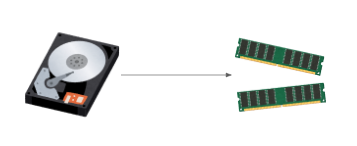

機械学習で扱うデータの特徴
1. 多くのファイルで構成されている
2. 学習前にデータシャッフル・データ拡張などの前処理を行う必要がある

In [1]:
import tensorflow as tf
import sys
import warnings
import numpy as np
warnings.filterwarnings('ignore')

### データ作成

In [7]:
# 元データ作成
'''コンビニ数に関するデータであることに意味はないので注意'''

import pandas as pd
import os

# データ取得・整形(変更)
url = 'https://todo-ran.com/t/kiji/10328'
dfs = pd.read_html(url)
df = dfs[2].iloc[:-2, :-1]
df.columns = ['rank', 'pref', '店舗数（総数）', '店舗数（per10万人）']

df.iloc[:, 2] = df.iloc[:, 2].str.replace('軒', '')
df.iloc[:, 2] = df.iloc[:, 2].str.replace(',', '')
df.iloc[:, 3] = df.iloc[:, 3].str.replace('軒', '')
df.iloc[:, 3] = df.iloc[:, 3].str.replace('.', '.')

df_original = df
df_original['filename'] = 0

os.makedirs('/content/data/normal/', exist_ok=True)
df_original.to_csv('./data/original_full_data.csv')

df = df.drop('pref', axis=1)
df = df.drop('店舗数（総数）', axis=1)
df = df.drop('店舗数（per10万人）', axis=1)
df = df.drop('rank', axis=1)

# dataディレクトリ作成
if not os.path.isdir('./data/'):
  os.makedirs('./data/normal/')

# full_data.csv作成
df.to_csv('./data/full_data.csv')

# 分割data.csv作成（実行せずともよい）
for i in range(6):
  df_split = df.iloc[i*6:(i+1)*6, :]
  df_split['filename'] = i+1
  df_split.to_csv(f"./data/normal/my_train_0{i+1}.csv")

df_split = df.iloc[37:, :]
df_split['filename'] = 7
df_split.to_csv('./data/normal/my_train_07.csv')

### dataset（概念）について

- DataAPIはdataset（概念）を中心に動いている
- dataset(概念)はデータ要素のシーケンス

- datasetを作り、そのdatasetに対して各種変換メソッドを呼び出して前処理を行う流れ。
- tensorflow.keras.Modelなどのfit()メソッドはNumPy配列やTensorオブジェクト以外にDatasetオブジェクトを渡すことも可能。

#### datasetの特性

In [8]:
# 任意のデータテンソル作成
X = tf.range(10)
X

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)>

In [9]:
# dataset作成
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [ ]:
# 要素を取り出す
for item in dataset:
  print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [ ]:
# # []を使って呼び出すことはできない
# try:
#   dataset[4]
# except:
#   print(sys.exc_info())

(<class 'TypeError'>, TypeError("'TensorSliceDataset' object is not subscriptable"), <traceback object at 0x7f046df3ef00>)


#### 変換メソッドを呼び出して変換

各種メソッド例
- repeat()： 繰り返す
- batch(): 個数を指定してバッチ化
- map(): 個々の要素を一括変換
- apply(): 全体変換
- unbatch(): バッチ化解除
- filter(): 条件に合うものを抽出
- take(): 取り出す
- shuffle(): シャッフルする

In [ ]:
# repeat()の使用例
dataset_repeated = dataset.repeat(3)
for item in dataset_repeated:
  print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype

In [ ]:
# batch()の使用例
dataset_batched = dataset_repeated.batch(7)
for item in dataset_batched:
  print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


In [ ]:
# repeat()とbatch()の連鎖の例
print('-----')
dataset_repeated_batched = dataset.repeat(3).batch(7)
for item in dataset_repeated_batched:
  print(item)

print('-----')
dataset_repeated_batched = dataset.repeat(3).batch(7, drop_remainder=True)
for item in dataset_repeated_batched:
  print(item)

-----
tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)
-----
tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)


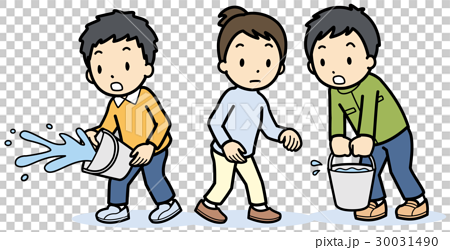

In [ ]:
# map()の使用例
'''map()メソッドにわたす関数はTF関数に変換可能なもの(12章参照)のみ'''
dataset_mapped = dataset.map(lambda x: x * 2)
for item in dataset_mapped:
  print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(18, shape=(), dtype=int32)


In [ ]:
# apply()の使用例
print('-----')
for i in dataset_batched:
  print(i)

print('-----')
#dataset_batched_unbatched = dataset_batched.apply(tf.data.experimental.unbatch()) # コアAPIに昇格済み
dataset_batched_unbatched = dataset_batched.unbatch()
for i in dataset_batched_unbatched:
  print(i)

-----
tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)
-----
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(0, shape

In [ ]:
# filter()の使用例
print('-----')
for item in dataset:
  print(item)

print('-----')
dataset_filtered = dataset.filter(lambda x: x < 5)
for item in dataset_filtered:
  print(item)

-----
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
-----
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


In [ ]:
# take()の使用例
for item in dataset.take(3):
  print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)


In [12]:
# shuffle()の使用例
dataset_shuffled = dataset.shuffle(buffer_size=5, seed=42)
for item in dataset_shuffled:
  print(item)


tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)


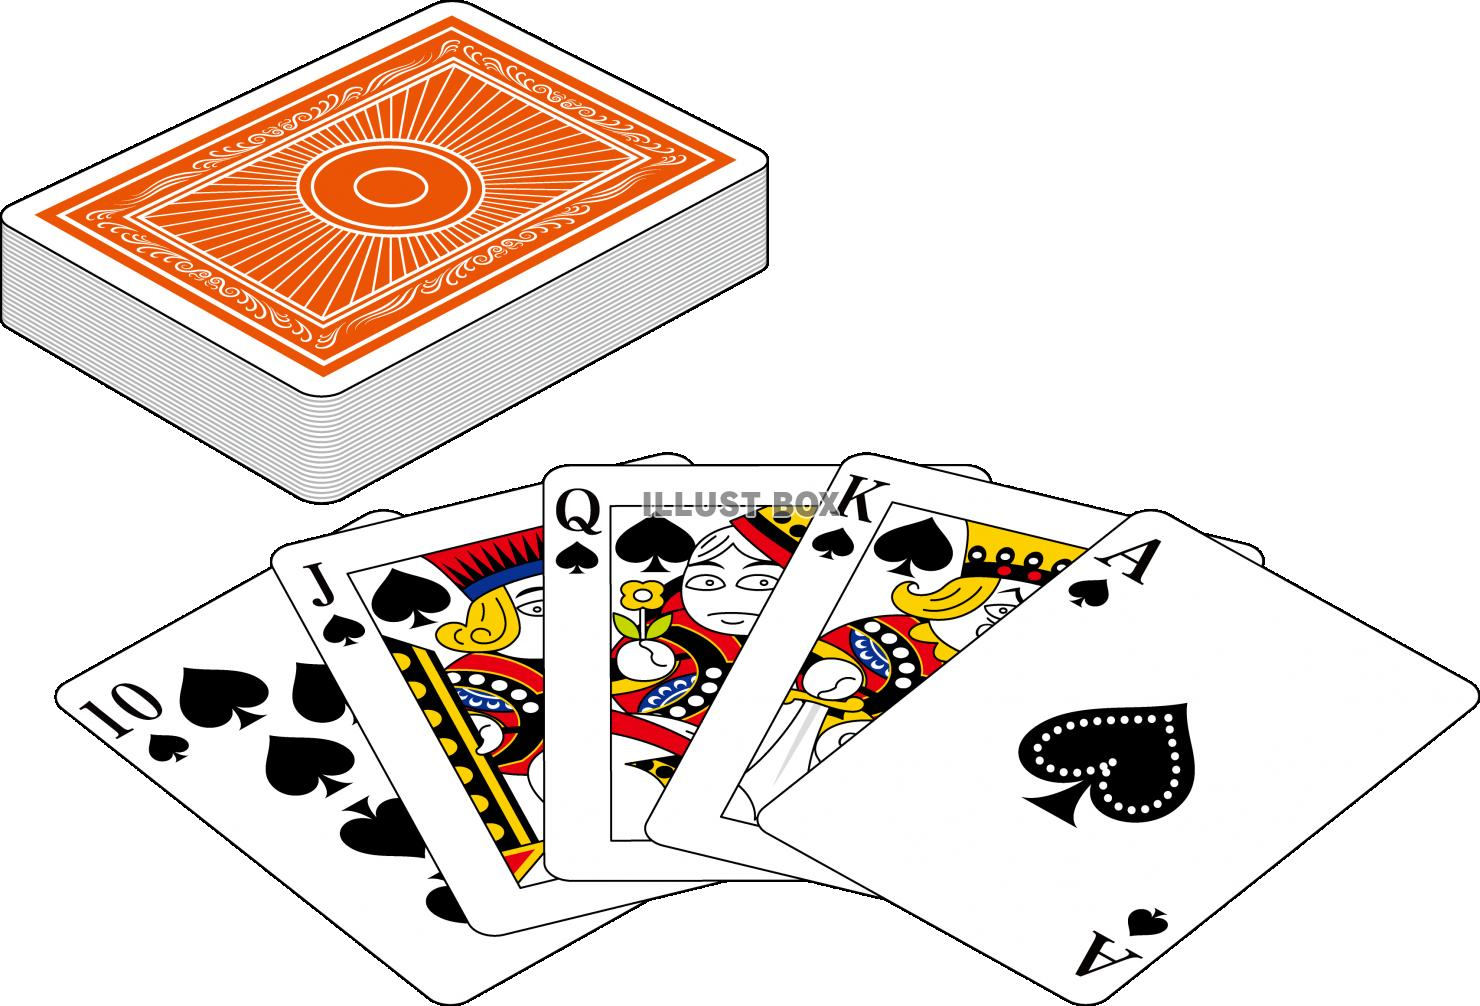

#### シャッフルの別手法1

- データセットがバッファと比べて大きすぎる場合、上述のshuffle()メソッドでは不十分な可能性がある
- そのような場合はソースデータ自体をシャッフルする手法がある  
→例：Linuxではshufコマンドでテキストファイルをシャッフル可能

In [ ]:
# shufコマンドの実行
!shuf /content/data/original_full_data.csv # 本来は不要な１行目を省いて処理

28,29,広島県,1205,43.01,0
9,10,富山県,485,46.83,0
32,33,山口県,565,42.07,0
4,5,茨城県,1432,49.92,0
38,39,新潟県,902,40.96,0
15,16,長野県,935,45.62,0
13,14,鳥取県,256,46.22,0
8,9,栃木県,921,47.62,0
0,1,北海道,3003,57.43,0
2,3,東京都,7405,52.65,0
1,2,山梨県,459,56.64,0
34,35,山形県,447,41.83,0
44,45,滋賀県,556,39.31,0
23,24,徳島県,320,44.46,0
26,27,愛媛県,583,43.65,0
39,40,宮崎県,435,40.65,0
41,42,神奈川県,3746,40.54,0
14,15,沖縄県,670,45.63,0
21,22,大阪府,3954,44.72,0
20,21,福岡県,2299,44.74,0
16,17,大分県,512,45.53,0
37,38,島根県,279,41.54,0
3,4,宮城県,1161,50.40,0
24,25,佐賀県,360,44.33,0
17,18,熊本県,786,45.19,0
29,30,千葉県,2701,42.96,0
,rank,pref,店舗数（総数）,店舗数（per10万人）,filename
46,47,奈良県,458,34.56,0
43,44,埼玉県,2929,39.87,0
35,36,京都府,1077,41.75,0
40,41,和歌山県,375,40.63,0
45,46,兵庫県,1988,36.35,0
7,8,愛知県,3642,48.26,0
27,28,岐阜県,854,43.14,0
5,6,福島県,904,49.29,0
22,23,三重県,790,44.60,0
33,34,鹿児島県,665,41.85,0
36,37,高知県,288,41.62,0
12,13,静岡県,1684,46.33,0
30,31,香川県,406,42.69,0
11,12,群馬県,900,46.38,0
25,26,福井県,337,43.91,0
10,11,秋田県,449,46.77,0
31,32,岡山県,797,42.18,0
42,43,長崎県,527

#### シャッフルの別手法2

テキスト  
「ソースデータがシャッフルされていても、通常はさらにシャッフルをかけたいところだろう。それをしないと、各エポックで同じ順番が繰り返され、モデルにバイアスがかかってしまう場合があるのだ。（たとえば、ソースデータの順序に偶然馬鹿げたパターンが現れたために）。インスタンスをさらにシャッフルするためによく使われているのは、ソースデータを複数のファイルに分割し、訓練中に無作為な順序で呼び出すというものである。しかし、これでは同じファイルに配置されたインスタンスは互いに近くに並ぶことになってしまう。それを避けるには、複数のファイルを無作為に選び、レコードをインターリーブ（互い違い）させながら同時に読み出せばよい。」

上記内容を、冒頭のコンビニデータセットを使って説明する。

In [14]:
# 訓練ファイルパスの作成
train_filepaths = []
file_names = os.listdir('/content/data/normal')
file_names.sort()
dir_name = '/content/data/normal/'

for i in range(len(file_names)):
  train_filepaths.append(dir_name + file_names[i])

train_filepaths

['/content/data/normal/my_train_01.csv',
 '/content/data/normal/my_train_02.csv',
 '/content/data/normal/my_train_03.csv',
 '/content/data/normal/my_train_04.csv',
 '/content/data/normal/my_train_05.csv',
 '/content/data/normal/my_train_06.csv',
 '/content/data/normal/my_train_07.csv']

In [16]:
# list_filesからdatasetを作成
'''デフォルトではlist_files()関数はファイルパスをシャッフルしたデータセットを返す'''
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42, shuffle=False) # 簡明さのためshuffle=False
for item in filepath_dataset:
  print(item)

tf.Tensor(b'/content/data/normal/my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'/content/data/normal/my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'/content/data/normal/my_train_03.csv', shape=(), dtype=string)
tf.Tensor(b'/content/data/normal/my_train_04.csv', shape=(), dtype=string)
tf.Tensor(b'/content/data/normal/my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'/content/data/normal/my_train_06.csv', shape=(), dtype=string)
tf.Tensor(b'/content/data/normal/my_train_07.csv', shape=(), dtype=string)


In [19]:
# interleave(互い違い)を行う
n_readers = 4 # 2のときはリフルシャッフルのイメージ
dataset_interleaved = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers
)

for item in dataset_interleaved:
  print(item)

tf.Tensor(b'0,1', shape=(), dtype=string)
tf.Tensor(b'6,2', shape=(), dtype=string)
tf.Tensor(b'12,3', shape=(), dtype=string)
tf.Tensor(b'18,4', shape=(), dtype=string)
tf.Tensor(b'1,1', shape=(), dtype=string)
tf.Tensor(b'7,2', shape=(), dtype=string)
tf.Tensor(b'13,3', shape=(), dtype=string)
tf.Tensor(b'19,4', shape=(), dtype=string)
tf.Tensor(b'2,1', shape=(), dtype=string)
tf.Tensor(b'8,2', shape=(), dtype=string)
tf.Tensor(b'14,3', shape=(), dtype=string)
tf.Tensor(b'20,4', shape=(), dtype=string)
tf.Tensor(b'3,1', shape=(), dtype=string)
tf.Tensor(b'9,2', shape=(), dtype=string)
tf.Tensor(b'15,3', shape=(), dtype=string)
tf.Tensor(b'21,4', shape=(), dtype=string)
tf.Tensor(b'4,1', shape=(), dtype=string)
tf.Tensor(b'10,2', shape=(), dtype=string)
tf.Tensor(b'16,3', shape=(), dtype=string)
tf.Tensor(b'22,4', shape=(), dtype=string)
tf.Tensor(b'5,1', shape=(), dtype=string)
tf.Tensor(b'11,2', shape=(), dtype=string)
tf.Tensor(b'17,3', shape=(), dtype=string)
tf.Tensor(b'23,4', sh

### データの前処理

#### housing分割データの作成

In [20]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

In [21]:
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

In [22]:
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

#### 作成したデータの確認

In [23]:
#DataFrameとして表示
import pandas as pd

pd.read_csv(train_filepaths[0]).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,3.5214,15.0,3.049945,1.106548,1447.0,1.605993,37.63,-122.43,1.442
1,5.3275,5.0,6.490060,0.991054,3464.0,3.443340,33.69,-117.39,1.687
2,3.1000,29.0,7.542373,1.591525,1328.0,2.250847,38.44,-122.98,1.621
3,7.1736,12.0,6.289003,0.997442,1054.0,2.695652,33.55,-117.70,2.621
4,2.0549,13.0,5.312457,1.085092,3297.0,2.244384,33.93,-116.93,0.956


In [24]:
# textとして表示
with open(train_filepaths[0]) as f:
    for i in range(5):
        print(f.readline(), end="")

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621
7.1736,12.0,6.289002557544757,0.9974424552429667,1054.0,2.6956521739130435,33.55,-117.7,2.621


In [27]:
train_filepaths

['datasets/housing/my_train_00.csv',
 'datasets/housing/my_train_01.csv',
 'datasets/housing/my_train_02.csv',
 'datasets/housing/my_train_03.csv',
 'datasets/housing/my_train_04.csv',
 'datasets/housing/my_train_05.csv',
 'datasets/housing/my_train_06.csv',
 'datasets/housing/my_train_07.csv',
 'datasets/housing/my_train_08.csv',
 'datasets/housing/my_train_09.csv',
 'datasets/housing/my_train_10.csv',
 'datasets/housing/my_train_11.csv',
 'datasets/housing/my_train_12.csv',
 'datasets/housing/my_train_13.csv',
 'datasets/housing/my_train_14.csv',
 'datasets/housing/my_train_15.csv',
 'datasets/housing/my_train_16.csv',
 'datasets/housing/my_train_17.csv',
 'datasets/housing/my_train_18.csv',
 'datasets/housing/my_train_19.csv']

In [26]:
X_mean, X_std

(array([ 3.89175860e+00,  2.86245478e+01,  5.45593655e+00,  1.09963474e+00,
         1.42428122e+03,  2.95886657e+00,  3.56464315e+01, -1.19584363e+02]),
 array([1.90927329e+00, 1.26409177e+01, 2.55038070e+00, 4.65460128e-01,
        1.09576000e+03, 2.36138048e+00, 2.13456672e+00, 2.00093304e+00]))

#### csvの1行を受け付け標準化する関数を作る

In [25]:
from IPython.core.debugger import Pdb

In [32]:
n_inputs = 8

def preprocess(line):
  defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)] # 最後のみ空配列
  fields = tf.io.decode_csv(line, record_defaults=defs) # スカラテンソルを返す
  x = tf.stack(fields[:-1]) # 一次元のテンソル配列へ
  y = tf.stack(fields[-1:]) # 一次元のテンソル配列へ
  Pdb().set_trace()
  return (x - X_mean) / X_std, y

In [ ]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

# defs
# fields
# x
# y
# tf.stack(fields[-1:])
# fields[-1:]
# q


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.7/bdb.py", line 332, in set_trace
    sys.settrace(self.trace_dispatch)



> <ipython-input-32-b62d2cc42ec8>(9)preprocess()
      5   fields = tf.io.decode_csv(line, record_defaults=defs) # スカラテンソルを返す
      6   x = tf.stack(fields[:-1]) # 一次元のテンソル配列へ
      7   y = tf.stack(fields[-1:]) # 一次元のテンソル配列へ
      8   Pdb().set_trace()
----> 9   return (x - X_mean) / X_std, y

ipdb> defs
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, <tf.Tensor: shape=(0,), dtype=float32, numpy=array([], dtype=float32)>]
ipdb> fields
[<tf.Tensor: shape=(), dtype=float32, numpy=4.2083>, <tf.Tensor: shape=(), dtype=float32, numpy=44.0>, <tf.Tensor: shape=(), dtype=float32, numpy=5.3232>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9171>, <tf.Tensor: shape=(), dtype=float32, numpy=846.0>, <tf.Tensor: shape=(), dtype=float32, numpy=2.337>, <tf.Tensor: shape=(), dtype=float32, numpy=37.47>, <tf.Tensor: shape=(), dtype=float32, numpy=-122.2>, <tf.Tensor: shape=(), dtype=float32, numpy=2.782>]
